# 08 Excercises: Vector time series, SNOTEL

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

## Objectives
* Explore spatial and temporal relationships of time series data, collected by networks of in-situ stations
* Learn about dynamic API queries, data ingestion into Pandas/GeoPandas
* Working with Pandas Timestamp and Python DateTime objects
* Explore spatial correlation of time series records
* Explore some simple interpolation routines to create continuous gridded values from sparse points
* Explore some fundamental concepts and metrics for snow science
* Visualize recent snow accumulation in your region

In [ ]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import contextily as ctx
import scipy.stats
import scipy.interpolate

In [ ]:
#Define variable to store current year
#curr_y = datetime.now().year
curr_y = pd.to_datetime("today").year
curr_y

2022

## Part 0: Prepare and load data
* The 08_SNOTEL_download notebook will prepare a geojson of SNOTEL sites with metadata and a pickled DataFrame containing snow depth time series for all sites
* May require ~30-40 minutes to query all sites and download data. I recommend you run the original notebook interactively in a separate window rather than running from this notebook with %run magic command.
* Once files are saved to disk, either copy to the directory with this notebook, or update the relative paths in the following cells.

In [ ]:
#%run 08_SNOTEL_download.ipynb

In [ ]:
sites_fn = 'snotel_conus_sites.json'
singlesite_pkl_fn = 'SNOTEL-SNWD_D_679_WA_SNTL.pkl'
allsites_pkl_fn = 'SNOTEL-SNWD_D_CONUS.pkl'

### Load state polygons

In [ ]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

### Load SNOTEL sites geojson

In [ ]:
#Note: geojson uses integer index, so need the `set_index` below
sites_gdf_all = gpd.read_file(sites_fn).set_index('index')
sites_gdf_all.head()

code             name network  elevation_m  \
index                                                                   
SNOTEL:301_CA_SNTL  301_CA_SNTL         Adin Mtn  SNOTEL  1886.712036   
SNOTEL:907_UT_SNTL  907_UT_SNTL      Agua Canyon  SNOTEL  2712.719971   
SNOTEL:916_MT_SNTL  916_MT_SNTL       Albro Lake  SNOTEL  2529.840088   
SNOTEL:908_WA_SNTL  908_WA_SNTL   Alpine Meadows  SNOTEL  1066.800049   
SNOTEL:302_OR_SNTL  302_OR_SNTL  Aneroid Lake #2  SNOTEL  2255.520020   

                                                        site_property  \
index                                                                   
SNOTEL:301_CA_SNTL  {'county': 'Modoc', 'state': 'California', 'si...   
SNOTEL:907_UT_SNTL  {'county': 'Kane', 'state': 'Utah', 'site_comm...   
SNOTEL:916_MT_SNTL  {'county': 'Madison', 'state': 'Montana', 'sit...   
SNOTEL:908_WA_SNTL  {'county': 'King', 'state': 'Washington', 'sit...   
SNOTEL:302_OR_SNTL  {'county': 'Wallowa', 'state': 'Oregon', 'site...   

                                       geometry  
index                                            
SNOTEL:301_CA_SNTL  POINT (-120.79192 41.23583)  
SNOTEL:907_UT_SNTL  POINT (-112.27118 37.52217)  
SNOTEL:916_MT_SNTL  POINT (-111.95902 45.59723)  
SNOTEL:908_WA_SNTL  POINT (-121.69847 47.77957)  
SNOTEL:302_OR_SNTL  POINT (-117.19258 45.21328)

## Part 1: Evaluate SNOTEL sites
* Create a plot using geopandas explore to get a better sense of distribution, site names and other fields

In [1]:
#sites_gdf_all.explore(column='elevation_m', cmap='inferno')

## Reproject the sites GeoDataFrame
* Can use the same Albers Equal Area projection from previous labs, or recompute based on bounds and center of SNOTEL sites

In [ ]:
aea_proj = '+proj=aea +lat_1=37.00 +lat_2=47.00 +lat_0=42.00 +lon_0=-114.27'
sites_gdf_all_proj = sites_gdf_all.to_crs(aea_proj)

In [ ]:
#Reproject states
states_gdf_proj = states_gdf.to_crs(aea_proj)

In [ ]:
#Isolate WA state polygon
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']

### Create a scatterplot and overlay the state polygons

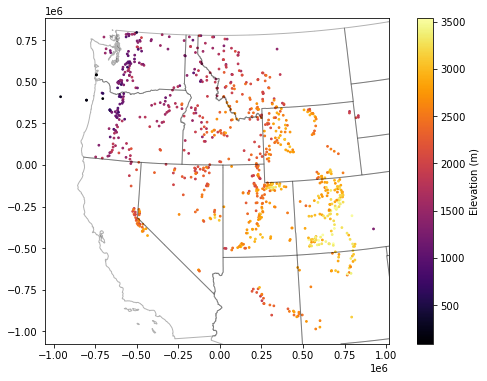

In [ ]:
f, ax = plt.subplots(figsize=(10,6))
sites_gdf_all_proj.plot(ax=ax, column='elevation_m', markersize=3, cmap='inferno', legend=True, legend_kwds={'label':'Elevation (m)'})
ax.autoscale(False)
states_gdf_proj.plot(ax=ax, facecolor='none', edgecolor='k', alpha=0.3);

### Isolate WA sites
* As with the GLAS point example, we could do `intersects` or a spatial join with WA polygon
* But probably easiest to filter records with 'WA' in the index
    * Note: need to convert the SNOTEL DataFrame index to `str`
    * `contains` might be a nice option
* Sanity check - note number of records and create a quick scatterplot to verify

In [ ]:
wa_idx = sites_gdf_all_proj.index.str.contains('WA')
sites_gdf_wa = sites_gdf_all_proj[wa_idx]
sites_gdf_wa.shape

(84, 6)

In [ ]:
#Prepare list of WA stations for use later in lab
#Can preserve as Pandas Index object
wa_stations = sites_gdf_all_proj.index[wa_idx]
#Or convert to list, if desired
#wa_stations = list(sites_gdf_all_proj.index[wa_idx])
wa_stations.shape

(84,)

In [ ]:
#Prepare a list of WA stations above a predefined elevation threshold
high_thresh = 1400 #meters
wa_stations_high = sites_gdf_wa.index[sites_gdf_wa['elevation_m'] > high_thresh]
wa_stations_high.shape

(32,)

## Create scatterplot to verify and add contextily basemap
* Can specify our AEA crs to the `crs` keyword in the ctx `add_basemap` function to reproject on the fly

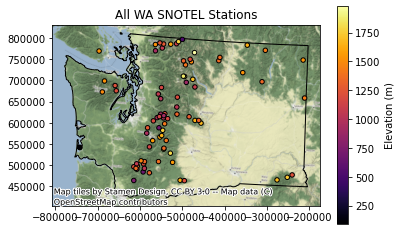

In [ ]:
f, ax = plt.subplots()
wa_state.plot(ax=ax, facecolor='none', edgecolor='black')
sites_gdf_wa.plot(ax=ax, column='elevation_m', markersize=20, edgecolor='k', cmap='inferno', \
                  legend=True, legend_kwds={'label':'Elevation (m)'})
ctx.add_basemap(ax=ax, crs=sites_gdf_wa.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('All WA SNOTEL Stations');

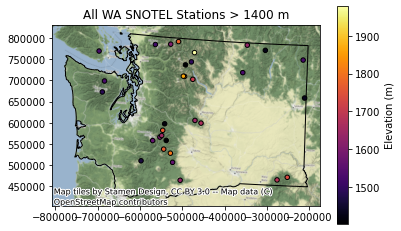

In [ ]:
f, ax = plt.subplots()
wa_state.plot(ax=ax, facecolor='none', edgecolor='black')
sites_gdf_wa.loc[wa_stations_high].plot(ax=ax, column='elevation_m', markersize=20, edgecolor='k', \
                                        cmap='inferno', legend=True, legend_kwds={'label':'Elevation (m)'})
ctx.add_basemap(ax=ax, crs=sites_gdf_wa.crs, source=ctx.providers.Stamen.Terrain)
ax.set_title('All WA SNOTEL Stations > %0.0f m' % high_thresh);

### Create a histogram showing elevation of WA sites and all sites in Western US
* These should be two histograms on the same axes
* Thought questions: 
    * *Do these elevations seem to provide a good sample of elevations where we expect snow to accumulate?*
    * *What do you notice about the WA sample?*

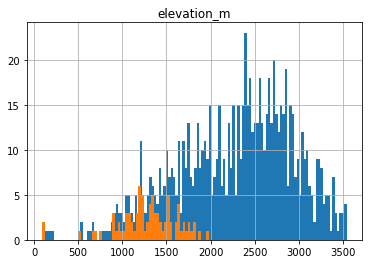

In [ ]:
ax = sites_gdf_all.hist('elevation_m', bins=128)
sites_gdf_wa.hist('elevation_m', bins=64, ax=ax);

### What is the highest site in WA?

In [ ]:
sitecode_max = sites_gdf_wa['elevation_m'].idxmax()
sites_gdf_wa.loc[sitecode_max]

code                                                   515_WA_SNTL
name                                                    Harts Pass
network                                                     SNOTEL
elevation_m                                            1978.151978
site_property    {'county': 'Okanogan', 'state': 'Washington', ...
geometry              POINT (-471261.4818625616 765568.9706388527)
Name: SNOTEL:515_WA_SNTL, dtype: object

### What is highest site in Western U.S.?

In [ ]:
sitecode_max = sites_gdf_all['elevation_m'].idxmax()
sites_gdf_all.loc[sitecode_max]

code                                                  1058_CO_SNTL
name                                                      Grayback
network                                                     SNOTEL
elevation_m                                            3541.775879
site_property    {'county': 'Rio Grande', 'state': 'Colorado', ...
geometry             POINT (-106.53782653808594 37.47032928466797)
Name: SNOTEL:1058_CO_SNTL, dtype: object

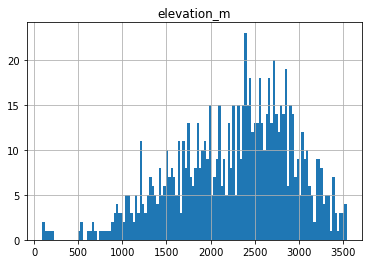

In [ ]:
sites_gdf_all.hist('elevation_m', bins=128);

### Which site is the highest elevation?

In [ ]:
sitecode = sites_gdf_all['elevation_m'].idxmax()
sites_gdf_all.loc[sitecode]

code                                                  1058_CO_SNTL
name                                                      Grayback
network                                                     SNOTEL
elevation_m                                            3541.775879
site_property    {'county': 'Rio Grande', 'state': 'Colorado', ...
geometry             POINT (-106.53782653808594 37.47032928466797)
Name: SNOTEL:1058_CO_SNTL, dtype: object

## Part 2: Single site time series analysis

### Load single site time series
* This was for Paradise site on Mt. Rainer

In [ ]:
sitecode = 'SNOTEL:679_WA_SNTL'
values_df = pd.read_pickle(singlesite_pkl_fn)

In [ ]:
values_df.head()

value qualifiers censor_code        date_time_utc  \
datetime                                                                       
2006-08-18 00:00:00+00:00    0.0          E          nc  2006-08-18T00:00:00   
2006-08-19 00:00:00+00:00    0.0          E          nc  2006-08-19T00:00:00   
2006-08-20 00:00:00+00:00    0.0          E          nc  2006-08-20T00:00:00   
2006-08-21 00:00:00+00:00    0.0          E          nc  2006-08-21T00:00:00   
2006-08-22 00:00:00+00:00    0.0          E          nc  2006-08-22T00:00:00   

                          method_id method_code source_code  \
datetime                                                      
2006-08-18 00:00:00+00:00         0           0           1   
2006-08-19 00:00:00+00:00         0           0           1   
2006-08-20 00:00:00+00:00         0           0           1   
2006-08-21 00:00:00+00:00         0           0           1   
2006-08-22 00:00:00+00:00         0           0           1   

                          quality_control_level_code  
datetime                                              
2006-08-18 00:00:00+00:00                          1  
2006-08-19 00:00:00+00:00                          1  
2006-08-20 00:00:00+00:00                          1  
2006-08-21 00:00:00+00:00                          1  
2006-08-22 00:00:00+00:00                          1

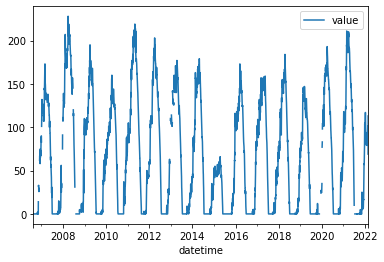

In [ ]:
values_df.plot();

In [ ]:
#Get number of decimal years between first and last observation
nyears = (values_df.index.max() - values_df.index.min()).days/365.25
nyears

15.51813826146475

### Compute the integer day of year (doy) and integer day of water year (dowy)
* Can get doy for each record with `df.index.dayofyear`
    * Add a new column to store these values
    * https://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DatetimeIndex.dayofyear.html
* For the day of water year calculation, you can offset the existing integer doy values so that Oct 1 = 1, then account for any values outside the expected range (e.g., less than 0, greater than 366)
    * https://en.wikipedia.org/wiki/Water_year
    * Add another column to store these values

In [ ]:
#Add DOY and DOWY column
#Need to revisit for leap year support
def add_dowy(df, col=None):
    if col is None:
        df['doy'] = df.index.dayofyear
    else:
        df['doy'] = df[col].dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear

In [ ]:
#Add new columns
add_dowy(values_df)

In [ ]:
#Quick sanity check around beginning of WY, make sure Oct 1 = 1
values_df[f'{curr_y-1}-09-28':f'{curr_y-1}-10-03']

In [ ]:
#Quick sanity check for calendar year end/start values
values_df[f'{curr_y-1}-12-29':f'{curr_y}-01-03']

### Compute statistics for each day of water year, using values from all years
* Seems like a Pandas groupby/agg might work here
* Stats should at least include min, max, mean, and median

In [ ]:
stat_list = ['count','min','max','mean','std','median','mad']

In [ ]:
doy_stats = values_df.groupby('dowy').agg(stat_list)['value']
doy_stats

count  min  max    mean       std  median       mad
dowy                                                     
1        16  0.0  9.0  0.6250  2.247221     0.0  1.093750
2        16  0.0  8.0  0.5000  2.000000     0.0  0.937500
3        16  0.0  9.0  0.6250  2.247221     0.0  1.093750
4        16  0.0  5.0  0.5625  1.364734     0.0  0.914062
5        16  0.0  5.0  0.5625  1.412740     0.0  0.914062
...     ...  ...  ...     ...       ...     ...       ...
361      16  0.0  1.0  0.0625  0.250000     0.0  0.117188
362      16  0.0  1.0  0.0625  0.250000     0.0  0.117188
363      16  0.0  1.0  0.0625  0.250000     0.0  0.117188
364      16  0.0  1.0  0.1250  0.341565     0.0  0.218750
365      16  0.0  3.0  0.2500  0.774597     0.0  0.437500

[365 rows x 7 columns]

## Create a plot of these aggregated dowy values
* Your output independent variable (x-axis) should be day of water year (1-366), and dependent variable (y-axis) should be median value for that day of year, computed using values from all available years
    * You may have to explicitly specify the x and y valuese for your plot function
* Something like the 30-year mean and median here: https://www.nwrfc.noaa.gov/snow/plot_SWE.php?id=AFSW1
* Extra credit: add shaded regions for standard deviation or normalized median absolute deviation (nmad) for each doy to show spread in values over the full record

## Add the daily snow depth values for the current water year
* Can use pandas indexing here with simple strings ('YYYY-MM-DD'), or Timestamp objects
    * Standard slicing also works with `:`
* Make sure to `dropna` to remove any records missing data
* Add this to your plot

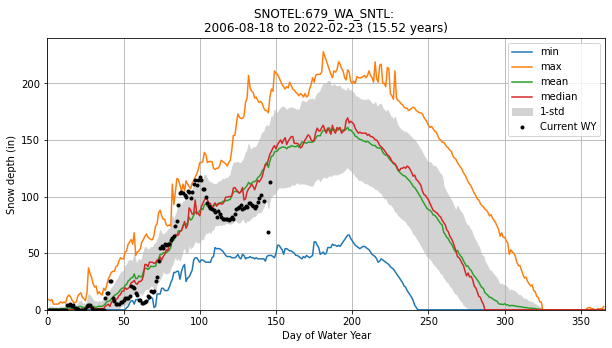

### For most recent snow depth value in the record, what is the percentage of "normal"
* This will be the snow depth from Wednesday or whenever you ran the download script
* Normal can be defined by long-term median for the same dowy across all years at the site

## Part 3: Western U.S. time series analysis

### Load pickled DataFrame

In [ ]:
snwd_df = pd.read_pickle(allsites_pkl_fn)
snwd_df.head()

SNOTEL:301_CA_SNTL  SNOTEL:907_UT_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:916_MT_SNTL  SNOTEL:908_WA_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:302_OR_SNTL  SNOTEL:1000_OR_SNTL  \
datetime                                                             
1984-10-01 00:00:00+00:00                 NaN                  NaN   
1984-10-02 00:00:00+00:00                 NaN                  NaN   
1984-10-03 00:00:00+00:00                 NaN                  NaN   
1984-10-04 00:00:00+00:00                 NaN                  NaN   
1984-10-05 00:00:00+00:00                 NaN                  NaN   

                           SNOTEL:303_CO_SNTL  SNOTEL:1030_CO_SNTL  \
datetime                                                             
1984-10-01 00:00:00+00:00                 NaN                  NaN   
1984-10-02 00:00:00+00:00                 NaN                  NaN   
1984-10-03 00:00:00+00:00                 NaN                  NaN   
1984-10-04 00:00:00+00:00                 NaN                  NaN   
1984-10-05 00:00:00+00:00                 NaN                  NaN   

                           SNOTEL:304_OR_SNTL  SNOTEL:306_ID_SNTL  ...  \
datetime                                                           ...   
1984-10-01 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-02 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-03 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-04 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-05 00:00:00+00:00                 NaN                 NaN  ...   

                           SNOTEL:872_WY_SNTL  SNOTEL:873_OR_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:874_CO_SNTL  SNOTEL:875_WY_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:876_MT_SNTL  SNOTEL:877_AZ_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:1228_UT_SNTL  SNOTEL:1197_UT_SNTL  \
datetime                           

### Convert snow depth inches to cm
* Use these values for the remainder of the lab

### Create a histogram of all snow depth values
* Use the Pandas `stack` function here, otherwise you will end up with histograms for each station
* Consider using log scale, as you likely have a spike for days with 0 snow depth (several months of each year!)

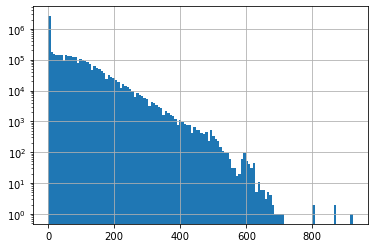

In [ ]:
f, ax = plt.subplots()
snwd_df.stack().hist(bins=128, ax=ax, log=True);

### Get the total count of operational stations on each day and plot over time
* Thought question:
    * *Can you identify years where a large number of new snow depth sensors were added to the network?*

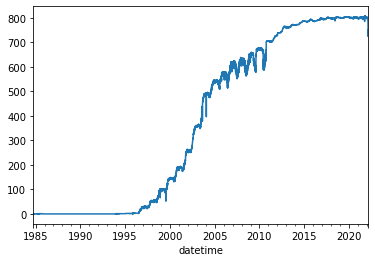

## Part 4: Temporal correlation of snow depth for nearby stations 
* Can use Paradise ('SNOTEL:679_WA_SNTL') and nearby station identified on the labeled folium plot above
* Plot the time series from both stations
* Can also use dropna here, but careful about methodology (`any` vs `all`, vs `thresh`)
    * https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [ ]:
#Highest site
#site1 = 'SNOTEL:863_WA_SNTL'
#site2 = 'SNOTEL:692_WA_SNTL'

In [ ]:
#Paradise and nearby sites
site1 = 'SNOTEL:679_WA_SNTL'
site2 = 'SNOTEL:1085_WA_SNTL'
site3 = 'SNOTEL:1257_WA_SNTL'
site4 = 'SNOTEL:941_WA_SNTL'
site5 = 'SNOTEL:642_WA_SNTL'

### Start with two nearby stations

In [ ]:
site_list = [site1,site2]
#Use corresponding colors in line and location scatterplots
color_list = ['C%i' % i for i in range(len(site_list))]

In [ ]:
snwd_df[site_list]

SNOTEL:679_WA_SNTL  SNOTEL:1085_WA_SNTL
datetime                                                          
1984-10-01 00:00:00+00:00                 NaN                  NaN
1984-10-02 00:00:00+00:00                 NaN                  NaN
1984-10-03 00:00:00+00:00                 NaN                  NaN
1984-10-04 00:00:00+00:00                 NaN                  NaN
1984-10-05 00:00:00+00:00                 NaN                  NaN
...                                       ...                  ...
2022-02-15 00:00:00+00:00              241.30               203.20
2022-02-16 00:00:00+00:00              251.46               203.20
2022-02-17 00:00:00+00:00              256.54               203.20
2022-02-18 00:00:00+00:00                 NaN               203.20
2022-02-19 00:00:00+00:00              243.84               198.12

[13656 rows x 2 columns]

#### Limit to records where both have valid data (drop NaN)

In [ ]:
snwd_df[site_list].dropna(thresh=2)

SNOTEL:679_WA_SNTL  SNOTEL:1085_WA_SNTL
datetime                                                          
2006-10-05 00:00:00+00:00                0.00                 0.00
2006-10-06 00:00:00+00:00                0.00                 0.00
2006-10-07 00:00:00+00:00                0.00                 0.00
2006-10-08 00:00:00+00:00                0.00                 0.00
2006-10-09 00:00:00+00:00                0.00                 0.00
...                                       ...                  ...
2022-02-14 00:00:00+00:00              233.68               198.12
2022-02-15 00:00:00+00:00              241.30               203.20
2022-02-16 00:00:00+00:00              251.46               203.20
2022-02-17 00:00:00+00:00              256.54               203.20
2022-02-19 00:00:00+00:00              243.84               198.12

[5426 rows x 2 columns]

### Plot location and time series

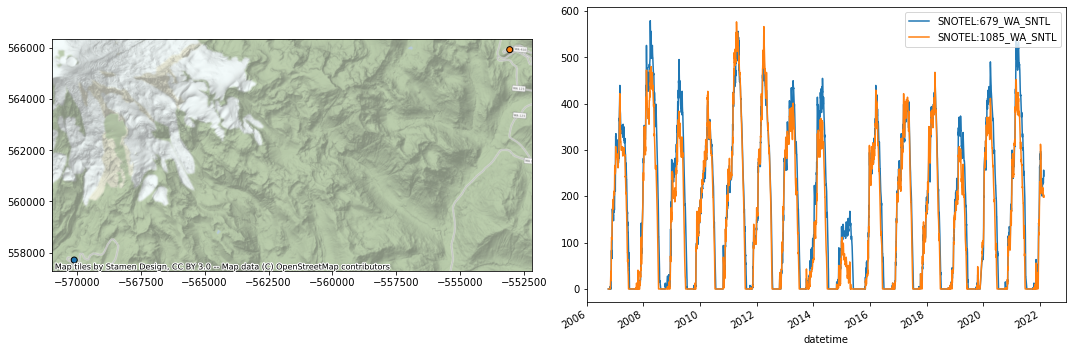

In [ ]:
f, axa = plt.subplots(1,2,figsize=(15,5))
sites_gdf_wa.loc[site_list].plot(facecolor=color_list, edgecolor='k', ax=axa[0])
ctx.add_basemap(ax=axa[0], crs=sites_gdf_wa.crs, source=ctx.providers.Stamen.Terrain, alpha=0.7)
snwd_df[site_list].dropna(thresh=2).plot(ax=axa[1])
plt.tight_layout()

### Consider seasonal variability in snow depth evolution for the two sites
* Create a scatterplot showing snow depth from site 1 on the y axis and site 2 on the x axis, with color ramp representing DOWY
* The points should fall on the 1:1 line if the snow depth evolution was identical
* Consider a cyclical color ramp like 'twilight' here, so values of 1 and 365 will have similar color

### Add doy and dowy columns

In [ ]:
#Add column for dowy
add_dowy(snwd_df)

In [ ]:
snwd_df[[*site_list,'dowy']].dropna(thresh=2)

SNOTEL:679_WA_SNTL  SNOTEL:1085_WA_SNTL  dowy
datetime                                                                
2006-08-18 00:00:00+00:00                0.00                  NaN   322
2006-08-19 00:00:00+00:00                0.00                  NaN   323
2006-08-20 00:00:00+00:00                0.00                  NaN   324
2006-08-21 00:00:00+00:00                0.00                  NaN   325
2006-08-22 00:00:00+00:00                0.00                  NaN   326
...                                       ...                  ...   ...
2022-02-15 00:00:00+00:00              241.30               203.20   138
2022-02-16 00:00:00+00:00              251.46               203.20   139
2022-02-17 00:00:00+00:00              256.54               203.20   140
2022-02-18 00:00:00+00:00                 NaN               203.20   141
2022-02-19 00:00:00+00:00              243.84               198.12   142

[5664 rows x 3 columns]

In [ ]:
#Determine max values to use for axes limits
max_snwd = int(np.ceil(snwd_df[[*site_list]].dropna(thresh=2).max().max()))

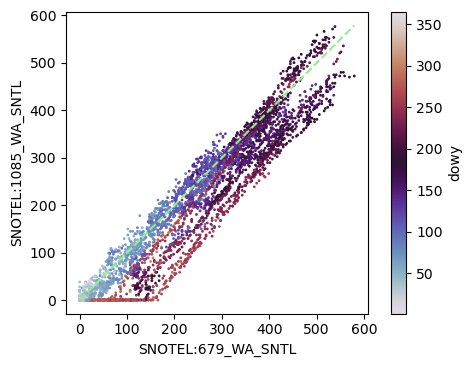

In [ ]:
f,ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
snwd_df[[*site_list,'dowy']].dropna(thresh=2).plot.scatter(x=site1,y=site2,c='dowy',cmap='twilight', s=1,ax=ax);
ax.plot(range(0,max_snwd), range(0,max_snwd), color='lightgreen', ls='--');

*Looks like 679 has greater snow depth later in the season, compared to 1085*

## Determine Pearson's correlation coefficient for the two time series
* https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
* See the Pandas `corr` method
    * This should properly handle nan under the hood!

In [ ]:
snwd_corr = snwd_df[site_list].corr()
snwd_corr

SNOTEL:679_WA_SNTL  SNOTEL:1085_WA_SNTL
SNOTEL:679_WA_SNTL             1.000000             0.969174
SNOTEL:1085_WA_SNTL            0.969174             1.000000

*As expected, these two records are highly correlated!*

### Now repeat for several nearby sites

In [ ]:
site_list = [site1,site2,site3,site4,site5]
#Use corresponding colors in line and location scatterplots
color_list = ['C%i' % i for i in range(len(site_list))]

In [ ]:
mygdf = sites_gdf_wa.loc[site_list]
mygdf

code         name network  elevation_m  \
index                                                                 
SNOTEL:679_WA_SNTL    679_WA_SNTL     Paradise  SNOTEL  1563.624023   
SNOTEL:1085_WA_SNTL  1085_WA_SNTL  Cayuse Pass  SNOTEL  1597.151978   
SNOTEL:1257_WA_SNTL  1257_WA_SNTL  Skate Creek  SNOTEL  1149.095947   
SNOTEL:941_WA_SNTL    941_WA_SNTL       Mowich  SNOTEL   963.168030   
SNOTEL:642_WA_SNTL    642_WA_SNTL   Morse Lake  SNOTEL  1648.968018   

                                                         site_property  \
index                                                                    
SNOTEL:679_WA_SNTL   {'county': 'Pierce', 'state': 'Washington', 's...   
SNOTEL:1085_WA_SNTL  {'county': 'Pierce', 'state': 'Washington', 's...   
SNOTEL:1257_WA_SNTL  {'county': 'Lewis', 'state': 'Washington', 'si...   
SNOTEL:941_WA_SNTL   {'county': 'Pierce', 'state': 'Washington', 's...   
SNOTEL:642_WA_SNTL   {'county': 'Yakima', 'state': 'Washington', 's...   

                                           geometry  
index                                                
SNOTEL:679_WA_SNTL   POINT (-570102.829 557709.249)  
SNOTEL:1085_WA_SNTL  POINT (-553060.628 565941.972)  
SNOTEL:1257_WA_SNTL  POINT (-577759.243 542830.006)  
SNOTEL:941_WA_SNTL   POINT (-584219.828 575219.336)  
SNOTEL:642_WA_SNTL   POINT (-548802.595 569633.965)

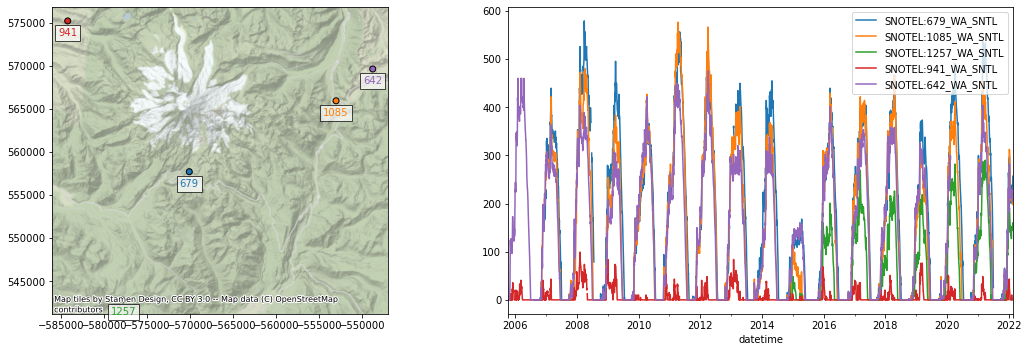

In [ ]:
f, axa = plt.subplots(1,2,figsize=(15,5))
mygdf.plot(facecolor=color_list, edgecolor='k', ax=axa[0])
for x, y, label, c in zip(mygdf.geometry.x, mygdf.geometry.y, mygdf.code.str.split('_').str[0], color_list):
    axa[0].annotate(label, xy=(x,y), xytext=(0, -15), ha='center', textcoords="offset points", color=c, bbox=dict(boxstyle="square",fc='w',alpha=0.7))
ctx.add_basemap(ax=axa[0], crs=sites_gdf_wa.crs, source=ctx.providers.Stamen.Terrain, alpha=0.7)
snwd_df[site_list].dropna(thresh=2).plot(ax=axa[1])
#snwd_df[site_list].dropna(how='all').plot(ax=axa[1])
plt.tight_layout()

In [ ]:
#The Pandas `corr` should properly handle nans
snwd_corr = snwd_df[site_list].corr()
snwd_corr

SNOTEL:679_WA_SNTL  SNOTEL:1085_WA_SNTL  \
SNOTEL:679_WA_SNTL             1.000000             0.969174   
SNOTEL:1085_WA_SNTL            0.969174             1.000000   
SNOTEL:1257_WA_SNTL            0.911083             0.941665   
SNOTEL:941_WA_SNTL             0.423361             0.420001   
SNOTEL:642_WA_SNTL             0.952133             0.977724   

                     SNOTEL:1257_WA_SNTL  SNOTEL:941_WA_SNTL  \
SNOTEL:679_WA_SNTL              0.911083            0.423361   
SNOTEL:1085_WA_SNTL             0.941665            0.420001   
SNOTEL:1257_WA_SNTL             1.000000            0.494260   
SNOTEL:941_WA_SNTL              0.494260            1.000000   
SNOTEL:642_WA_SNTL              0.908164            0.408776   

                     SNOTEL:642_WA_SNTL  
SNOTEL:679_WA_SNTL             0.952133  
SNOTEL:1085_WA_SNTL            0.977724  
SNOTEL:1257_WA_SNTL            0.908164  
SNOTEL:941_WA_SNTL             0.408776  
SNOTEL:642_WA_SNTL             1.000000

### Visualize correlation values for different combinations of stations

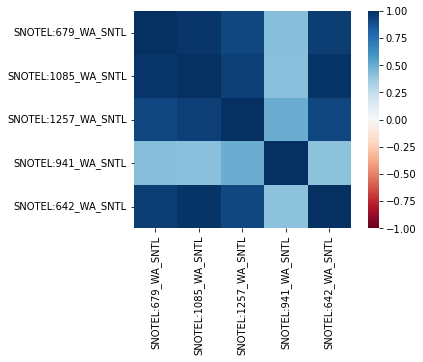

In [ ]:
import seaborn as sns
sns.heatmap(snwd_corr, cmap='RdBu', vmin=-1, vmax=1, square=True);
#Not sure why 0.5 values are not identical color?
#snwd_corr.style.background_gradient(cmap='RdBu').set_precision(2)

### Extra Credit: Consider spatial variability of these correlation coefficients
* Select a reference station
* Compute correlation scores with this reference station
    * Join the correlation score values with original GeoDataFrame containing Point geometries
* Create a scatter plot (map) with color ramp showing correlation score

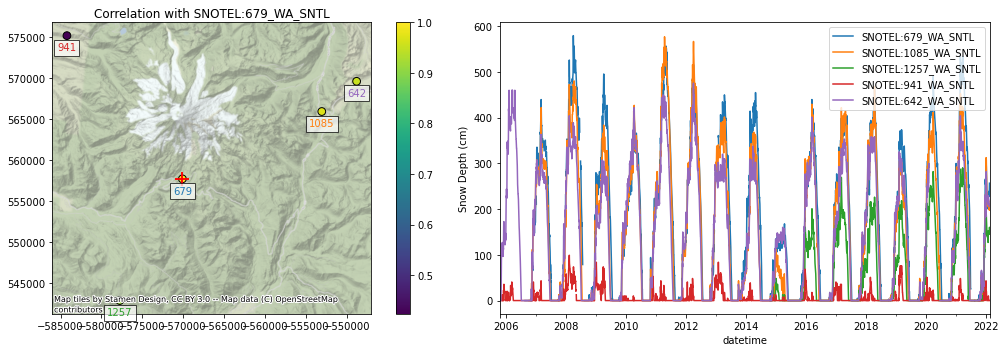

### Extra Credit: Consider the correlation as a function of distance from the reference station
* Compute the distance in km between the reference station and all other stations
* Create a plot of correlation coefficient vs. distance

## Part 5: Correlation for all SNOTEL sites across Western U.S.

* Consider correlation vs. distance
* Consider correlation vs. elevation (relative to ref station elevation)

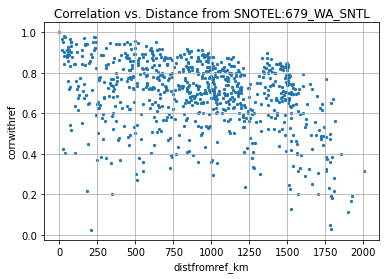

### Create a map to consider spatial variability in correlation

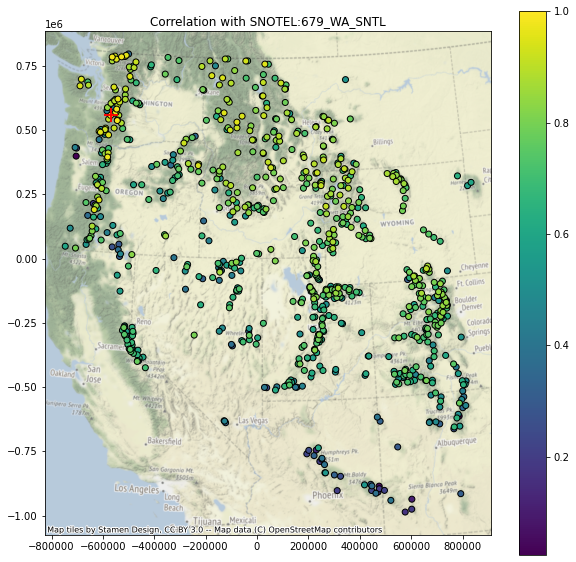

## Part 6: Compute daily snow depth difference for all stations
* This represents daily snow accumulation or ablation
* See the Pandas `diff` function
    * Make sure you specify the axis properly to difference over time (not station to station), and sanity check
    * This should correctly account for missing values, but need to double-check
* Sanity check with `tail` - most values should be relatively small (+/-1-6)

SNOTEL:301_CA_SNTL  SNOTEL:907_UT_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:916_MT_SNTL  SNOTEL:908_WA_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:302_OR_SNTL  SNOTEL:1000_OR_SNTL  \
datetime                                                             
1984-10-01 00:00:00+00:00                 NaN                  NaN   
1984-10-02 00:00:00+00:00                 NaN                  NaN   
1984-10-03 00:00:00+00:00                 NaN                  NaN   
1984-10-04 00:00:00+00:00                 NaN                  NaN   
1984-10-05 00:00:00+00:00                 NaN                  NaN   

                           SNOTEL:303_CO_SNTL  SNOTEL:1030_CO_SNTL  \
datetime                                                             
1984-10-01 00:00:00+00:00                 NaN                  NaN   
1984-10-02 00:00:00+00:00                 NaN                  NaN   
1984-10-03 00:00:00+00:00                 NaN                  NaN   
1984-10-04 00:00:00+00:00                 NaN                  NaN   
1984-10-05 00:00:00+00:00                 NaN                  NaN   

                           SNOTEL:304_OR_SNTL  SNOTEL:306_ID_SNTL  ...  \
datetime                                                           ...   
1984-10-01 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-02 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-03 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-04 00:00:00+00:00                 NaN                 NaN  ...   
1984-10-05 00:00:00+00:00                 NaN                 NaN  ...   

                           SNOTEL:874_CO_SNTL  SNOTEL:875_WY_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:876_MT_SNTL  SNOTEL:877_AZ_SNTL  \
datetime                                                            
1984-10-01 00:00:00+00:00                 NaN                 NaN   
1984-10-02 00:00:00+00:00                 NaN                 NaN   
1984-10-03 00:00:00+00:00                 NaN                 NaN   
1984-10-04 00:00:00+00:00                 NaN                 NaN   
1984-10-05 00:00:00+00:00                 NaN                 NaN   

                           SNOTEL:1228_UT_SNTL  SNOTEL:1197_UT_SNTL  \
datetime                                                              
1984-10-01 00:00:00+00:00                  NaN                  NaN   
1984-10-02 00:00:00+00:00                  NaN                  NaN   
1984-10-03 00:00:00+00:00                  NaN                  NaN   
1984-10-04 00:00:00+00:00                  NaN                  NaN   
1984-10-05 00:00:00+00:00                  NaN                  NaN   

                           SNOTEL:878_WY_SNTL  SNOTEL:1033_CO_SNTL  doy  dowy  
datetime    

### Create plot showing this daily accumulation for all sites
* Can start by trying to plot a subset of sites - every 10th, for example (`snwd_df_diff.iloc[:, ::10].plot()`)
    * May require a few minutes to plot all ~800 sites
* Adjusting the ylim appropriately
* Probably best to set `legend=False` in your plot call
* Add a black horizontal line at 0 with linewidth=0.5

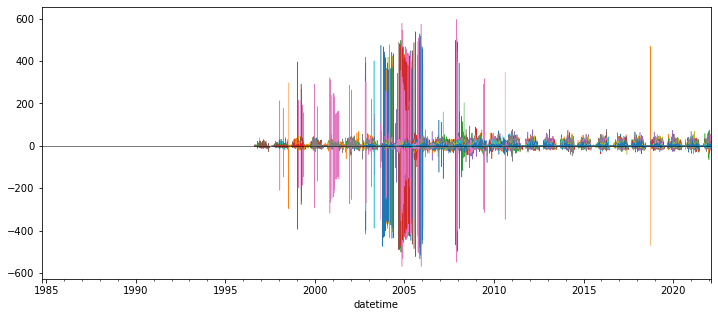

In [ ]:
f,ax = plt.subplots(figsize=(12,5))
snwd_df_diff.iloc[:, ::10].plot(ax=ax,legend=False, lw=0.5)
ax.axhline(0, color='k', lw=0.5);

### Interpretation (Provide brief written response these questions) ✍️
* Do you think you can confidently identify large snow accumulation events using these difference values?
* Are some periods or sensors noisier than others?
* When the measured snow depth increases from one day to the next, what happened?
* When the measured snow depth decreases from one day to the next, what happened?
    * Hint: during the winter, some days never get above freezing, but snow depths still decrease...

## Extra Credit: Design filters to remove artifacts and outliers
* Could likely design a series of filters to remove outliers from original snow depth value time series and the difference time series for each site
* One idea:
    * What is the maximum amount of snowfall you would expect in a 24-hour period? 
    * How about the maximum decrease in snow depth in a 24-hour period?
* Can also combine multiple stations for another round of filters:
    * If a single station shows an increase of 2 m, but all others show a decrease, is that realistic?
* Other considerations:
    * mean +/- (3 * std) is often used to remove outliers from normally distributed values (but is this the case for your difference values?)
    * Z-score threshold (same idea): https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
* Maybe come back to this if you have time later, for now, just note the presence of measurement errors

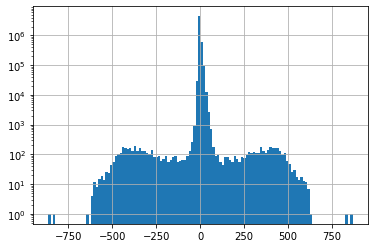

In [ ]:
f, ax = plt.subplots()
snwd_df_diff.stack().hist(bins=128, ax=ax, log=True);

In [ ]:
snwd_df_diff.count().sum()

5168686

In [ ]:
#Mean and std for entire dataset before filtering
print(np.nanmean(snwd_df_diff.values), np.nanstd(snwd_df_diff.values))

0.003724250225299048 13.679468269059988


In [ ]:
#Assume maximum daily increase due to snowfall of 1.7 m
max_diff = 170
idx = snwd_df_diff > max_diff
#Assume maximum daily decrease due to melting/compaction of 0.7 m
min_diff = -70
idx = idx | (snwd_df_diff < min_diff)
snwd_df_diff[idx] = np.nan

In [ ]:
snwd_df_diff.count().sum()

5162242

In [ ]:
f=3
#Mean and std for entire dataset
print(np.nanmean(snwd_df_diff.values), np.nanstd(snwd_df_diff.values))

0.016367276078881998 4.965466882690038


In [ ]:
snwd_df_diff.mean().mean()

0.014769593393007707

In [ ]:
snwd_df_diff.std().mean()

4.632062977915513

In [ ]:
#Mean and std for each site
#idx = (snwd_df_diff - snwd_df_diff.mean()).abs().gt(f*snwd_df_diff.std())
#snwd_df_diff[idx] = np.nan

In [ ]:
#Mean and std for each day
#idx = (snwd_df_diff.sub(snwd_df_diff.mean(axis=1), axis=0)).abs().gt(f*snwd_df_diff.std(axis=1))
#snwd_df_diff[idx] = np.nan

In [ ]:
snwd_df_diff.median(axis=1).max()

15.240000000000009

In [ ]:
snwd_df_diff.count().sum()

5162242

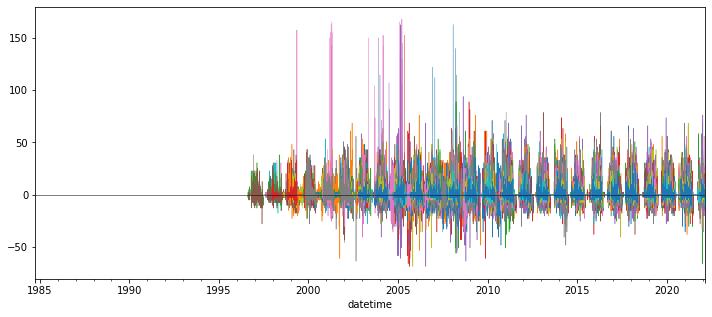

In [ ]:
f,ax = plt.subplots(figsize=(12,5))
snwd_df_diff.iloc[:,::10].plot(ax=ax,legend=False, lw=0.5)
ax.axhline(0, color='k', lw=0.5);

*Better!  But still some outliers that can be removed with improved filters...*

## For now, let's aggregate across all stations using robust statistics
* Create a plot showing the median difference values across all stations for all days in the record with valid data
    * Again, careful about which axis along which you're computing the median
* You may need to adjust the ylim to bring out detail if you haven't removed outliers

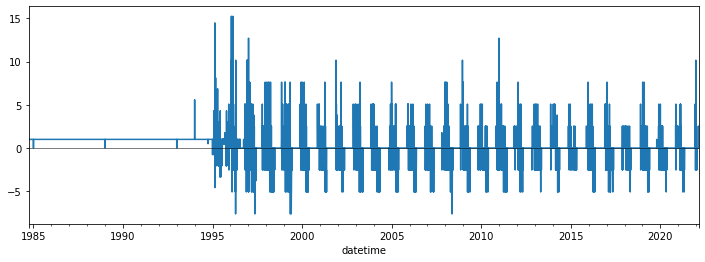

### Create a similar plot, but limit to current water year
* Starting Oct 1 of previous calendar year
* Can you identify any big snow events?  
* I added shading to show spread of values (+/-nmad), but this is optional

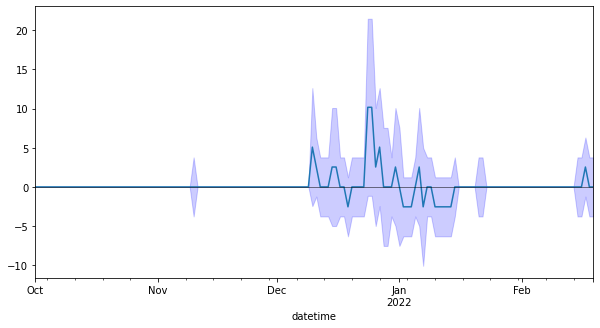

### Now plot just the WA stations (use the `wa_stations` index we already calculated)
* Can do this with `snwd_df_diff.loc[:,wa_stations]`
    * Note: some stations we identified earlier may be missing from the larger time series data frame!
    * Can remove those as shown below
* What date had the greatest daily snow accumulation across all stations in WA? ✍️
    * May be useful to plot using `%matplotlib widget` or `hvplot()` for interactive tooltips to show dates as you hover over peaks

In [ ]:
print(wa_stations.shape)
wa_stations = wa_stations[wa_stations.isin(snwd_df_diff.columns)]
print(wa_stations.shape)

(84,)
(75,)


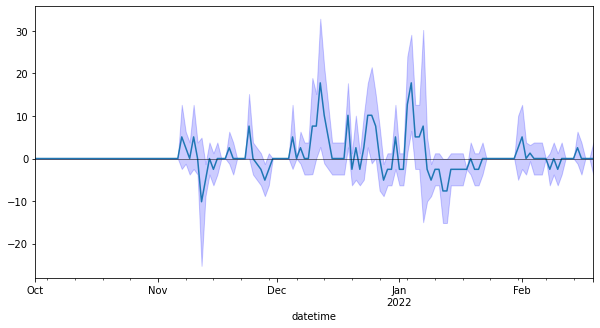

### Extra Credit: Repeat for WA high elevation sites (defined earlier)
* Do you notice a difference?

## Part 7: Compute statistics for all time series at all SNOTEL sites, plot and evaluate spatial variability
* So, now we're going back to our GeoDataFrame containing Point geometry for all sites, and adding some key metrics

In [ ]:
#Define a list to store our new column names
col_list = []

In [ ]:
#Define the GeoDataFrame to use (projected sites)
#We will append columns to this dataframe using new calculated values for all sites
gdf = sites_gdf_all_proj

### Compute the count of valid daily records (not NaN) available for each station
* Which station has the greatest number of observations for SNWD_D?
* Note, we should drop the doy and dowy columns here

In [ ]:
snwd_df.count(axis=0).sort_values().tail()

SNOTEL:651_OR_SNTL     9374
SNOTEL:763_UT_SNTL     9585
SNOTEL:347_MT_SNTL    10295
doy                   13656
dowy                  13656
dtype: int64

### Add the count of valid time series records for each station a new column in our original WA sites GeoDataframe (the one containing lat/lon and other site attributes)
* Should be straightforward, let Pandas do the work to match site index values
* Verify your site DataFrame now has a 'Total Observation Count (days)' column

In [ ]:
col = 'Total Observation Count (days)'
gdf[col] = snwd_df.count(axis=0)
col_list.append(col)
gdf.head()

code             name network  elevation_m  \
index                                                                   
SNOTEL:301_CA_SNTL  301_CA_SNTL         Adin Mtn  SNOTEL  1886.712036   
SNOTEL:907_UT_SNTL  907_UT_SNTL      Agua Canyon  SNOTEL  2712.719971   
SNOTEL:916_MT_SNTL  916_MT_SNTL       Albro Lake  SNOTEL  2529.840088   
SNOTEL:908_WA_SNTL  908_WA_SNTL   Alpine Meadows  SNOTEL  1066.800049   
SNOTEL:302_OR_SNTL  302_OR_SNTL  Aneroid Lake #2  SNOTEL  2255.520020   

                                                        site_property  \
index                                                                   
SNOTEL:301_CA_SNTL  {'county': 'Modoc', 'state': 'California', 'si...   
SNOTEL:907_UT_SNTL  {'county': 'Kane', 'state': 'Utah', 'site_comm...   
SNOTEL:916_MT_SNTL  {'county': 'Madison', 'state': 'Montana', 'sit...   
SNOTEL:908_WA_SNTL  {'county': 'King', 'state': 'Washington', 'sit...   
SNOTEL:302_OR_SNTL  {'county': 'Wallowa', 'state': 'Oregon', 'site...   

                                          geometry  corrwithref  \
index                                                             
SNOTEL:301_CA_SNTL  POINT (-544242.606 -64533.121)     0.582154   
SNOTEL:907_UT_SNTL  POINT (176554.295 -496466.990)     0.454722   
SNOTEL:916_MT_SNTL   POINT (179938.808 403391.205)     0.849032   
SNOTEL:908_WA_SNTL  POINT (-556800.380 667749.727)     0.942259   
SNOTEL:302_OR_SNTL  POINT (-228997.265 362101.867)     0.941587   

                    Total Observation Count (days)  
index                                               
SNOTEL:301_CA_SNTL                          8603.0  
SNOTEL:907_UT_SNTL                          8540.0  
SNOTEL:916_MT_SNTL                          9291.0  
SNOTEL:908_WA_SNTL                          6458.0  
SNOTEL:302_OR_SNTL                          7586.0

## Your Turn! Calculate at least 3 of the following metrics
#### Extra credit: Try all of them!

### Add a column for the long-term max snow depth on record for each site
* Might need to be careful about measurement errors here - maybe look at values and filter obvious outliers
* Could also consider a threshold for minimum count of valid days

### Add a column for the long-term mean snow depth at each site
* Note: to do this properly, probably want to remove any values near 0 (no snow on the ground) before computing the mean
    * Maybe a threshold of 1 cm?

### Add a column for the daily difference (snow accumulation) at all sites for a recent storm event
* Note, Pandas uses a `Timestamp` object that wraps the commond Python `datetime` objects
* pd.Timestamp('YYYY-MM-DD')
* Note, you may need to use `mydataframe.loc[pd.Timestamp('YYYY-MM-DD')]`

### Add a column for the current snow depth for a recent day (say, yesterday) in the time series
* Use a relative index value here to get the latest Timestamp (like -1, or maybe -2)
    * Note that using timestamp for today could have limited returns, as latest data from some stations have not been integrated into database
* Note that the index is not a string, it is a Pandas Timestamp object: `pd.Timestamp('2019-02-06 00:00:00')`

### Add a column for the percent of "normal" snow depth for most recent day
* We did this for a single site earlier
* Need to compute the long-term median snow depth for this same doy at all sites
    * See earlier example, where we grouped by `df.index.dayofyear`, then aggregated

### Add a column for _total_ snow accumulation in the past week
* Use a slice of pandas Timestamps to index
    * Can define using today's Timestamp and then calculate the timestamp from 7 days ago using a Timedelta object
* You'll want to only include the days with positive snow accumulation (excluding days where no new snow fell or snow depth decreased)
    * Can then compute a sum

## Create some scatterplots to review these new metrics
* Hint: remove NaN records on the fly before plotting - see the `dropna()` method
    * Best to apply after isolating the column you want to plot, consider `mydataframe[['max', 'geometry]].dropna().plot(column='max', ...)`
* Can plot separately, or create a figure with multiple subplots, and add titles/labels appropriately
* I create a function to create the plot, and then looped over each column name I wanted to plot

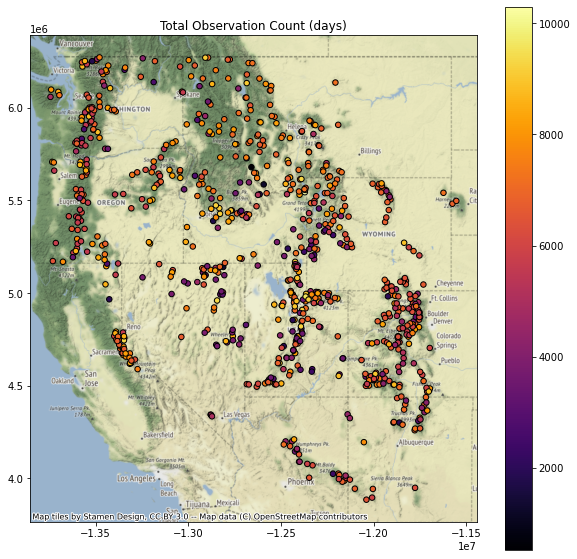

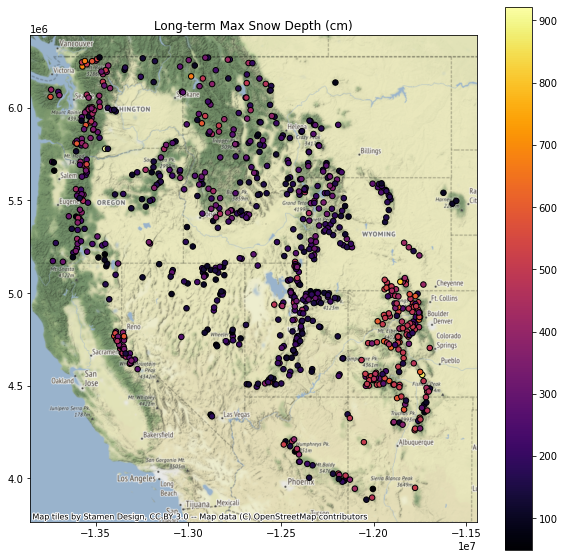

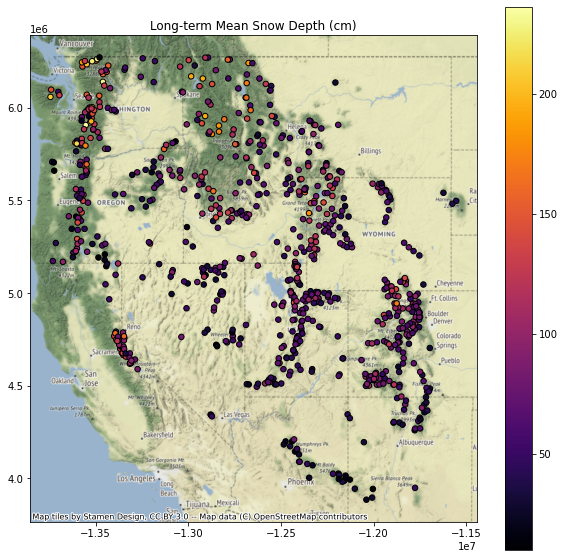

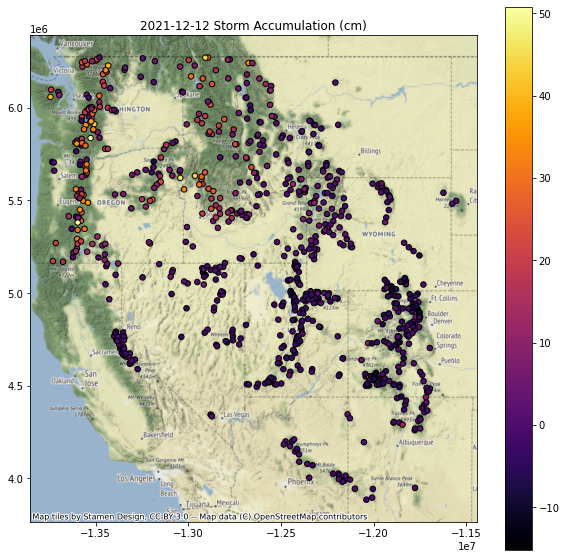

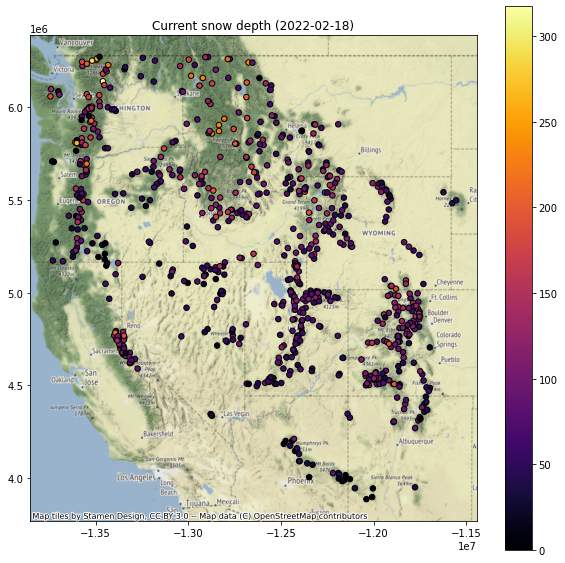

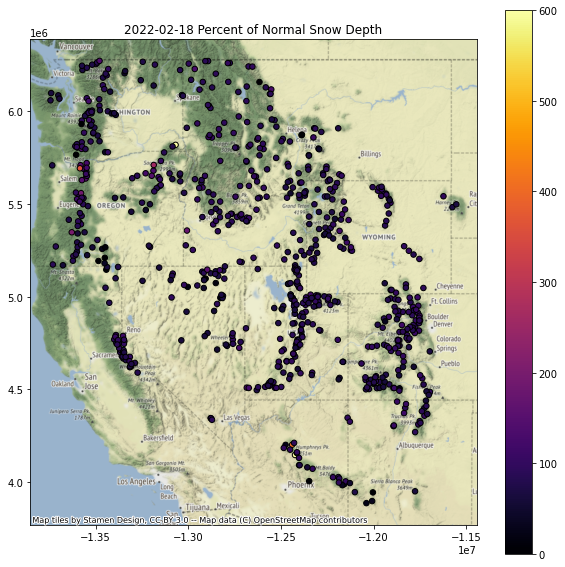

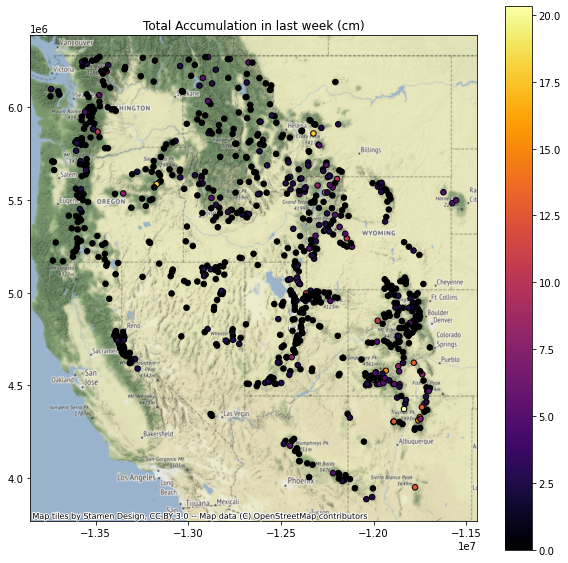

In [ ]:
for col in col_list:
    f, ax = plt.subplots(figsize=(10,10))
    ax.set_title(col)
    gdf[[col, 'geometry']].to_crs('EPSG:3857').dropna().plot(ax=ax, column=col, markersize=30, edgecolor='k', cmap='inferno', legend=True)
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.Terrain)

## Replot percent of normal (descending sort)
* Plotting order can be important when you have larger markers that overlap - you can end up with very different interpretations depending on values displayed on top of the plot
* Let's explorer this by reviewing the "percent of normal snow depth" plot with ascending and descending order
* This should be pretty straightforward to sort and plot
    * `gdf.to_crs('EPSG:3857')[[col, 'geometry']].dropna().sort_values(by=col, ascending=False).plot()`
    * Need to set the column name appropriately

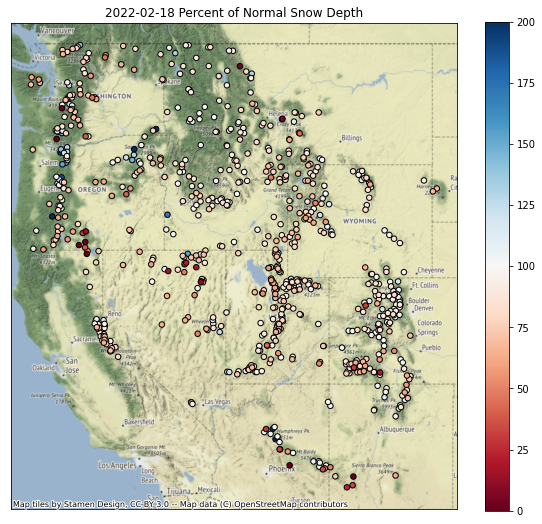

## Replot percent of normal (ascending sort)

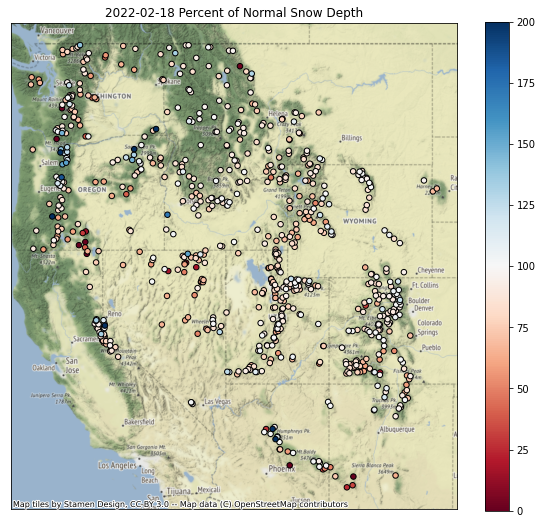

*Note: plotting order can be important, leading to different interpreations! For example, compare values over the Sierra Nevada in CA in the above two plots.*

## Can you identify the SNOTEL site with: ✍️
* Greatest long-term maximum snow depth
    * *Are we sure that this is the absolute true maximum?* *What happens if the snow gets higher than the instrument?*
* Greatest accumulation in past week
    * *Where should I go skiing this weekend if I like deep snow?*

### Extra Credit: Repeat the above plotting for the WA state extent

### Extra Credit: Limit your analysis to only include stations with >15 years of data

## Part 8: Interpolating sparse values
* Let's create continuous gridded values (AKA Raster!) from our sparse point data
* Note that we wouldn't do this in practice, as there are much more sophisticated approaches one should use here, but let's use this dataset to explore some basic interpolation approaches
* We'll use the `scipy.interpolate.griddata` function here, using 'nearest' to start, and `scipy.interpolate.Rbf`

### Specify the column name of variable to interpolate

In [ ]:
col = f'Current snow depth ({ts.date()})'
#col = f'{ts_str} Storm Accumulation (cm)'
#col = f'Total Accumulation in last week (cm)'

### Review the comments/code in the following cells, then run

In [ ]:
#Extract the column and geometry, drop NaNs
gdf_dropna = gdf.to_crs(aea_proj)[[col,'geometry']].dropna()
#Pull out (x,y,val)
x = gdf_dropna.geometry.x
y = gdf_dropna.geometry.y
z = gdf_dropna[col]
#Get min and max values
zlim = (z.min(), z.max())

In [ ]:
#Compute the spatial extent of the points - we will interpolate across this domain
bounds = gdf_dropna.total_bounds

In [ ]:
#Spatial interpolation step of 10 km
dx,dy = (10000,10000)

In [ ]:
#Limit to WA state
#bounds = wa_state.total_bounds
#dx,dy = (1000,1000)

In [ ]:
#Create 1D arrays of grid cell coordinates in the x and y directions
xi = np.arange(np.floor(bounds[0]), np.ceil(bounds[2]),dx)
yi = np.arange(np.floor(bounds[1]), np.ceil(bounds[3]),dy)

In [ ]:
#Function that will plot the interpolated grid, overlaying original values
def plotinterp(zi):
    f, ax = plt.subplots(figsize=(10,10))
    #Define extent of the interpolated grid in projected coordinate system, using matplotlib extent format (left, right, bottom, top)
    mpl_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
    #Plot the interpolated grid, providing known extent
    #Note: need the [::-1] to flip the grid in the y direction
    ax.imshow(zi[::-1,], cmap='inferno', extent=mpl_extent, clim=zlim)
    #Overlay the original point values with the same color ramp
    gdf_dropna.plot(ax=ax, column=col, cmap='inferno', markersize=30, edgecolor='0.5', vmin=zlim[0], vmax=zlim[1], legend=True)
    #Overlay WA polygon
    #wa_state.plot(ax=ax, facecolor='none', edgecolor='white')
    ax.autoscale(False)
    states_gdf_proj.plot(ax=ax, facecolor='none', edgecolor='white')
    #Make sure aspect is equal
    ax.set_aspect('equal')

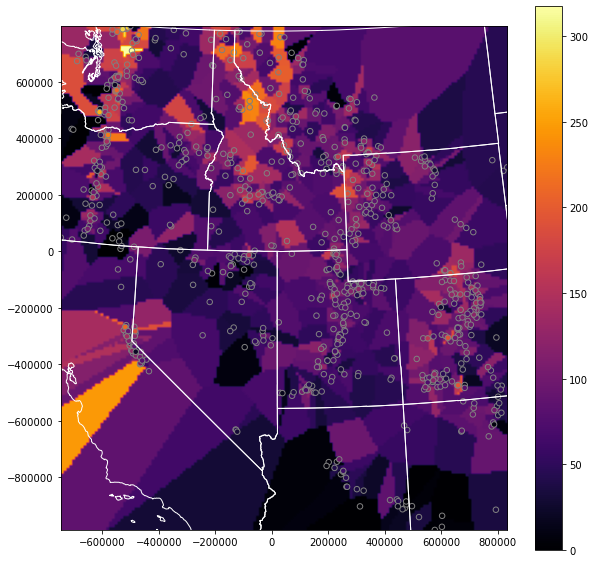

In [ ]:
#Create 2D grids from the xi and yi grid cell coordinates
xx, yy = np.meshgrid(xi, yi)
#Interpolate values using griddata
zi = scipy.interpolate.griddata((x,y), z, (xx, yy), method='nearest')
plotinterp(zi)

## Radial basis function interpolation
* https://en.wikipedia.org/wiki/Radial_basis_function_interpolation

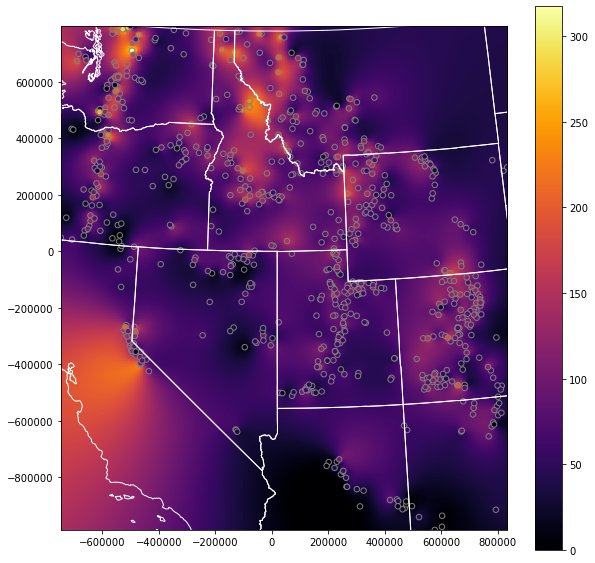

In [ ]:
#Use Radial basis function interpolation
f = scipy.interpolate.Rbf(x,y,z, function='linear')
zi = f(xx, yy)
plotinterp(zi)

### Explore this a bit
* Try a few different interpolation methods for griddata and Rbf
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html#scipy.interpolate.Rbf
* Extra Credit: Play around with some other unstructured data interpolation methods
    * https://docs.scipy.org/doc/scipy/reference/interpolate.html#multivariate-interpolation
    * Others outside of scipy.interpolate

### Write out the interpolated snow depth grid using rasterio (raster review)

In [ ]:
#Grid origin (center of pixel?)
origin = (xi.min(), yi.min())
print(origin)
#Grid cell size
print(dx, dy)

(-746621.0, -986535.0)
10000 10000


In [ ]:
#https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
import rasterio as rio

transform = rio.transform.from_origin(xi.min(), yi.max(), dx, dy)

out_fn = 'snotel_interp_test.tif'
new_dataset = rio.open(out_fn, 'w', driver='GTiff',
                            height = zi.shape[0], width = zi.shape[1],
                            count=1, dtype=str(zi.dtype),
                            crs=gdf.crs,
                            transform=transform)

new_dataset.write(zi[::-1,], 1)
new_dataset.close()

In [ ]:
!ls -l $out_fn

-rw-r--r-- 1 jovyan users 226947 Feb 25 21:14 snotel_interp_test.tif


### Load from disk to verify

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 158, 'height': 179, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",42],PARAMETER["longitude_of_center",-114.27],PARAMETER["standard_parallel_1",37],PARAMETER["standard_parallel_2",47],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(10000.0, 0.0, -746621.0,
       0.0, -10000.0, 793465.0), 'tiled': False, 'interleave': 'band'}


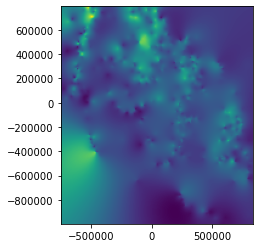

In [ ]:
from rasterio.plot import show
with rio.open(out_fn) as src:
    print(src.profile)
    show(src)

## Extra Credit: Clip interpolated grid to buffered radius around all stations
* Clip the interpolated rasters within 20 km of stations

## Extra Credit: Limit interpolation or clip to:
* Mountain ecoregion: https://www.epa.gov/eco-research/level-iii-and-iv-ecoregions-continental-united-states
* Mountain classes: https://rmgsc.cr.usgs.gov/gme/
* Observed recent snowcover mask derived from MODIS data for the corresponding date
    * See great resource **Snow Today** at the National Snow and Ice Data Center: https://nsidc.org/snow-today

## Extra Credit: Spatial Correlation, Semivariogram Analysis and Kriging
* I ran out of time on this, but showing some simple example code from skgstat

#### Resources:
* https://scikit-gstat.readthedocs.io/en/latest/
* https://scikit-learn.org/stable/modules/gaussian_process.html

#### Some useful examples:
* http://darribas.org/gds15/content/labs/lab_06.html  
* http://darribas.org/gds_scipy16/ipynb_md/04_esda.html

In [ ]:
!mamba install -c conda-forge -q -y scikit-gstat

In [ ]:
import skgstat as skg

In [ ]:
#These are elevation values for the sites
coords = np.stack([sites_gdf_all_proj.geometry.x.values, sites_gdf_all_proj.geometry.y.values], axis=1)
col = 'elevation_m'
vals = sites_gdf_all_proj[col].values

In [ ]:
#These are values from above interpolation
#coords = np.stack([x.values, y.values], axis=1)
#vals = z.values

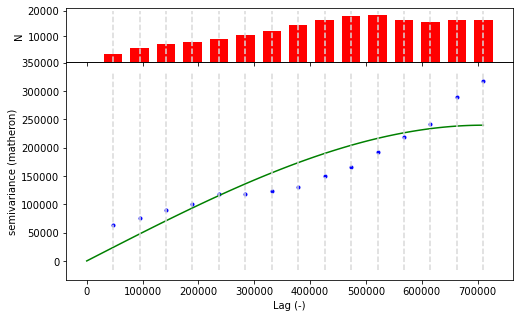

In [ ]:
V = skg.Variogram(coords, vals.flatten(), maxlag='median', n_lags=15, normalize=False)
fig = V.plot(show=False)

In [ ]:
print('Sample variance: %.2f   Variogram sill: %.2f' % (vals.flatten().var(), V.describe()['sill']))

Sample variance: 450311.11   Variogram sill: 239843.73


In [ ]:
print(V.describe())

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': 504396187723.1311, 'normalized_sill': 76153749776.40479, 'normalized_nugget': 0, 'effective_range': 710208.552274, 'sill': 239843.73263309486, 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': 710208.5522740001, 'n_lags': 15, 'verbose': False}, 'kwargs': {}}


In [ ]:
ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

In [ ]:
#ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)

In [ ]:
#np.mgrid[x.min():x.max():100j, y.min():y.max():100j].shape

In [ ]:
# build the target grid
#x = coords[:, 0]
#y = coords[:, 1]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

(0.0, 100.0)

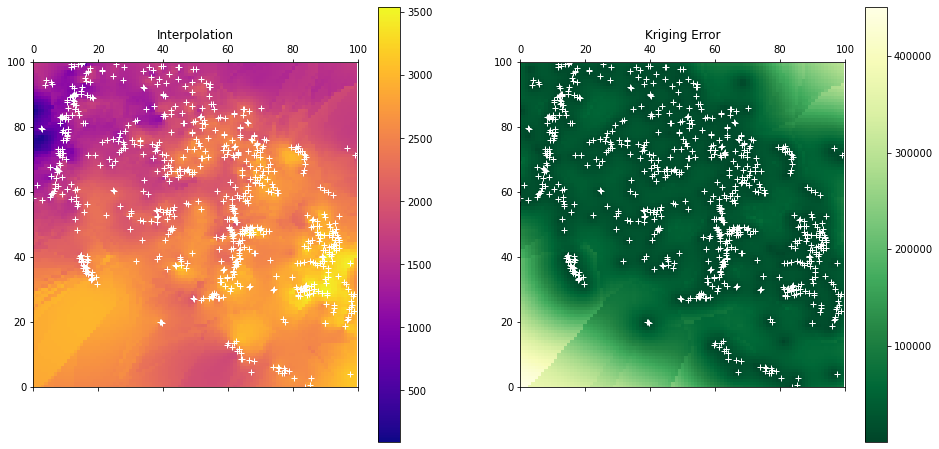

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=vals.min(), vmax=vals.max())
axes[0].set_title('Interpolation')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0, 100))
axes[0].set_ylim((0, 100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0, 100))
axes[1].set_ylim((0, 100))

## Extra Credit: Snow depth vs. elevation analysis for WA
* Let's look at snow depth across WA on the most recent day in the record
* Create a quick scatterplot of elevation vs. snow depth for all sites on this day
* Do you see a relationship?  

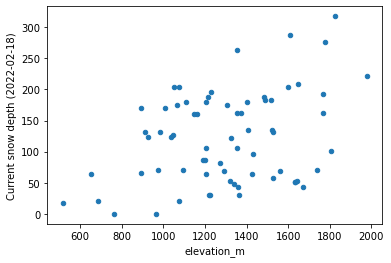

### Try elevation vs. long-term mean

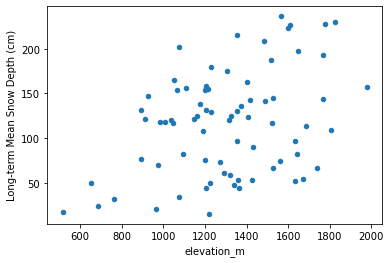

## Extra Credit: Linear regression of snow depth vs. elevation
* Several convenient options in Python.  Here are a few:
    * https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html 
    * https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html
* How good is your fit?
* Compare accumulation vs elevation for a recent storm event with abundant lowland snow (e.g., Feb 11) with another more typical accumulation event (where low elevations receive rain and mountains receive snow)

r-squared: 0.14440017996676394


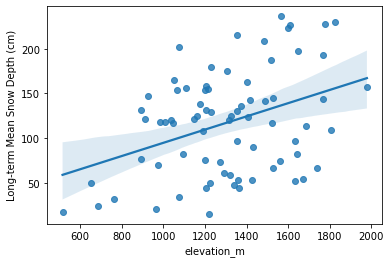

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Long-term Mean Snow Depth (cm)   R-squared:                       0.144
Model:                                        OLS   Adj. R-squared:                  0.133
Method:                             Least Squares   F-statistic:                     12.32
Date:                            Fri, 25 Feb 2022   Prob (F-statistic):           0.000772
Time:                                    21:15:07   Log-Likelihood:                -404.69
No. Observations:                              75   AIC:                             813.4
Df Residuals:                                  73   BIC:                             818.0
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          20.8555     28.204      0.739      0.462     -35.355      77.066
elevation_m     0.0740      0.021      3.510      0.001       0.032       0.116
==============================================================================
Omnibus:                       12.985   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                3.632
Skew:                           0.026   Prob(JB):                        0.163
Kurtosis:                       1.923   Cond. No.                     6.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Extra Credit: Consider other variables that could affect snow depth
* Distance from the coast (remember the Lab06 exercise calculating distance from WA perimiter?)
* Mean winter daily temperature (from PRISM)

## Extra credit (or, some additional items to explore)

If you have some time (or curiosity), feel free to explore some of these, or define your own questions.  This is a really rich dataset, and those of you interested in snow or hydrology may have some cool ideas.

1. Compute snow depth statistics across all sites grouping by Water Year (or by month/day range where snow is typically present)
1. Identify date of first major snow accumulation event each year, date of max snow depth, date of snow disappearance - any evolution over time?
1. Split sites into elevation bands and analyze various metrics
1. Perform watershed-scale analysis
1. Explore other interpolation methods for sparse data
1. Create an animated map of daily accumulation in WA for the past two weeks
1. Look at other variables for the SNOTEL sites (e.g., snow water equivalent, temperature data)
    * Note that WTEQ_D time series begin much earlier than SNWD_D
1. Create maps of snow density for WA using WTEQ_D and SNWD_D